# Running simulations of influenza spreading in cities

**About this tool:** in this Jupyter Notebook, you will design a city from scratch and then simulate an influenza outbreak inside it. By changing the spatial distributions of houses, factories, schools and businesses, you will determine patterns in people's mobility and thus influence the outcome of epidemics. 

A more in-depth description of the methods and theory that support this approach to urban health research are presented in the bioRxiV preprint **Understanding the role of urban design in disease spreading**. 

Below, we have added an example of the computational structure of our mathematical model. You will begin by setting some basic characteristics about the city and the disease you're modelling.

We begin by importing the necessary modules, defining our disease parameters and creating a hypothetical square city. Our code for Guadalajara is written in MATLAB and has some extra rings and bells (pre-processing of census data, hospitals, etc.) but follows the same structure. 

**Set city parameters**: 
1) total population and size of a rectangular city
2) Disease characteristics
3) Mobility parameters

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import matplotlib

matplotlib.rcParams['figure.figsize'] = [9, 6]

# CITY CHARACTERISTICS: population, horizontal dimensions (km) and model resolution (# of grid elements per axis)
city = {'N':2.5e5,'Lxy':np.array([15,18]),'Lres':np.array([20,25])}

# Disease parameters
disease = {'beta_adults':2.1e-4,'beta_children':15e-4,'gamma':1/4}


# Mobility parameters
mob = {'alpha':0.8,'kappa':80,'delta_r0':5,'b':1.75} 


**Generate a rectangular numerical grid for our city**

In [70]:
# Use parameters established above
gridx = np.linspace(0, city['Lxy'][0], city['Lres'][0],endpoint = False) + (city['Lxy'][0]/city['Lres'][0])/2
gridy = np.linspace(0, city['Lxy'][1], city['Lres'][1],endpoint = False) + (city['Lxy'][1]/city['Lres'][1])/2

GRIDX, GRIDY = np.meshgrid(gridx, gridy) # create rectangular arrays with (x,y) of neighborhood positions

GRIDX = np.reshape(GRIDX,(city['Lres'][0]*city['Lres'][1],1))
GRIDY = np.reshape(GRIDY, (city['Lres'][0]*city['Lres'][1],1))

dx = (gridx[1] - gridx[0])
dy = (gridy[1] - gridy[0])

# Standardize beta for the area of grid elements:
disease['beta_adults'] = disease['beta_adults']/dx/dy
disease['beta_children'] = disease['beta_children']/dx/dy

# List with locations of grid elements
city['xy'] = np.concatenate( (GRIDX, GRIDY), axis = 1)

# Matrix of distance between grid elements 
city['r_xy'] = np.sqrt( (GRIDX - np.transpose(GRIDX))**2 + (GRIDY - np.transpose(GRIDY))**2)

Neighborhoods in our city will now be numbered according to the order in which they appear in the array "city['xy']". 

The next thing we have to do is to **distribute the population and its activities**. We will do so by sampling from probability distributions. 

In [71]:
# POPULATION DENSITY

# Fraction of inhabitants that are children:
child_ratio = 0.3

# Determine population density using Rayleigh distributions
city['adults'] = np.random.rayleigh(0.8, size= city['Lres'])
city['children'] = np.random.rayleigh(0.9, size=city['Lres'])

# Fix number of inhabitants
dummy_norm = sum(sum(city['adults']*dx*dy))
city['adults'] = city['adults']*dx*dy/dummy_norm*city['N']*(1 - child_ratio)
dummy_norm = sum(sum(city['children']*dx*dy))
city['children'] = city['children']*dx*dy/dummy_norm*city['N']*child_ratio

#----------------------------------------------------------------

# DAILY ACTIVITIES
daily_trips = np.array([1.3, 0.7]) # number of daily trip made by adults and children respectively

# Distribute activities of the population using Power and Rayleigh distributions
city['adult_TAS'] = np.random.power(0.6,size = city['Lres'])
city['child_TAS'] = np.random.power(1.0,size = city['Lres'])

dummy_norm = sum(sum(city['adult_TAS']))
city['adult_TAS'] = city['adult_TAS']/dummy_norm*city['N']*(1-child_ratio)*daily_trips[0]

dummy_norm = sum(sum(city['child_TAS']))
city['child_TAS'] = city['child_TAS']/dummy_norm*city['N']*child_ratio*daily_trips[1]

**Let's see what our city looks like!**

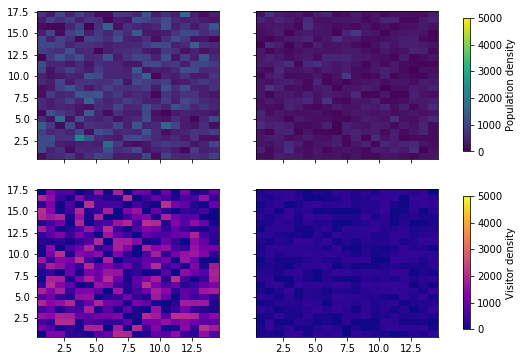

In [72]:
# Shape TAS and population to plot them in a grid
city['adult_TAS'] = np.reshape(city['adult_TAS'],(city['Lres'][0],city['Lres'][1]))
city['child_TAS'] = np.reshape(city['child_TAS'],(city['Lres'][0],city['Lres'][1]))

# Reshape population
city['adults'] = np.reshape(city['adults'],(city['Lres'][0],city['Lres'][1])) 
city['children'] = np.reshape(city['children'], (city['Lres'][0],city['Lres'][1]))

# PLOT!
cm = ['viridis','plasma']
img, axs = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, \
                                        squeeze = True)
#plt.subplot(2,2,1)
f1 = axs[0,0].pcolor(gridx, gridy, np.transpose(city['adults'])/dx/dy, cmap = cm[0])
axs[0,0].set_title = 'Adults'

#plt.subplot(2,2,2)
f2 = axs[0,1].pcolor(gridx, gridy, np.transpose(city['children'])/dx/dy, cmap = cm[0])
axs[0,1].set_title = 'Children'


#plt.subplot(2,2,3)
f3 = axs[1,0].pcolor(gridx, gridy, np.transpose(city['adult_TAS'])/dx/dy, cmap = cm[1])

#plt.subplot(2,2,4)
f4 = axs[1,1].pcolor(gridx, gridy, np.transpose(city['child_TAS'])/dx/dy, cmap = cm[1])

f3.set_clim(vmin = 0, vmax = 5000); 
f4.set_clim(vmin = 0, vmax = 5000);
f1.set_clim(vmin = 0, vmax = 5000); 
f2.set_clim(vmin = 0, vmax = 5000);

cbar = img.colorbar(f3, ax=axs[1, :], shrink=0.9); cbar.set_label('Visitor density')
cbar = img.colorbar(f1, ax=axs[0, :], shrink=0.9); cbar.set_label('Population density')

# Reshape TAS for usage:
city['adult_TAS'] = np.reshape(city['adult_TAS'],(1,city['Lres'][0]*city['Lres'][1]))
city['child_TAS'] = np.reshape(city['child_TAS'],(1, city['Lres'][0]*city['Lres'][1]))

# Reshape population
city['adults'] = np.reshape(city['adults'],(city['Lres'][0]*city['Lres'][1],1)) 
city['children'] = np.reshape(city['children'], (city['Lres'][0]*city['Lres'][1],1))

Now use that information to **generate origin-destination matrices**. The method followed here is closely described in the subsection *Inferred Mobility Patterns* of our manuscript. Basically, we use Trip Attraction Strength (TAS, defined by Jakimavicius and Burinskiene in 2005) to weigh radial displacements given by the gravity model obtained by Gonzalez et al (2008).

In origin destination matrices, the (m,n) element gives us the expected number of trips that a resident of grid element "m" will visit the locaiton "n" on a given day. Namely, rows represent origins while destinations are identified by different columns.

\begin{equation}
a
\end{equation}

In [73]:
# Origin-destination matrix for adults
mob['adult_OD'] =  ( city['r_xy'] + mob['delta_r0'])**(-mob['b']) * np.exp(- city['r_xy']/mob['kappa'])*city['adult_TAS']
# Fix number of daily trips
mob['adult_OD'] = mob['adult_OD']/np.reshape(np.sum(mob['adult_OD'],1),(len(city['xy']),1))*daily_trips[0]

# Now for children
mob['child_OD'] = (city['r_xy'] + mob['delta_r0'])**(-mob['b']) * np.exp(-city['r_xy']/mob['kappa'])*city['child_TAS']
mob['child_OD'] = mob['child_OD']/np.reshape(np.sum(mob['child_OD'],1),(len(city['xy']),1))*daily_trips[1]

We can now **verify the relationship between TAS and number of visitors** that a location receives.

(0, array([ 1614.87415753]))

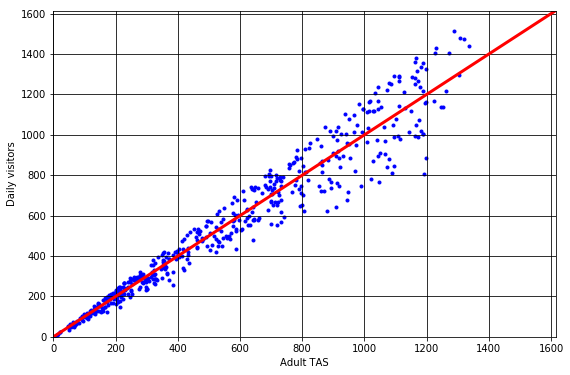

In [74]:
# Reshape population data into vector form to simplify multiplication with OD matrices

city['adults'] = np.reshape(city['adults'], (city['Lres'][0]*city['Lres'][1],1))
city['children'] = np.reshape(city['children'], (city['Lres'][0]*city['Lres'][1],1))

visitors = np.matmul( np.transpose(mob['adult_OD']), city['adults'],out = None) + \
    np.matmul( np.transpose(mob['child_OD']), city['children'])

plt.grid(color = 'k')
plt.scatter(city['adult_TAS'] + city['child_TAS'], visitors,marker = '.', color = 'b')
plt.xlabel('Adult TAS'); plt.ylabel('Daily visitors'); 
plt.plot([0, max(visitors) + 100],[0, max(visitors) + 100],color = 'r', linewidth = 3); 
plt.ylim((0, max(visitors) + 100)); plt.xlim((0, max(visitors) + 100))

And now we can calculate **Gini coefficients** for origins (population density) and destinations (visitor density)

Text(0.69,0.32,'$G_{origins}$ = 0.22')

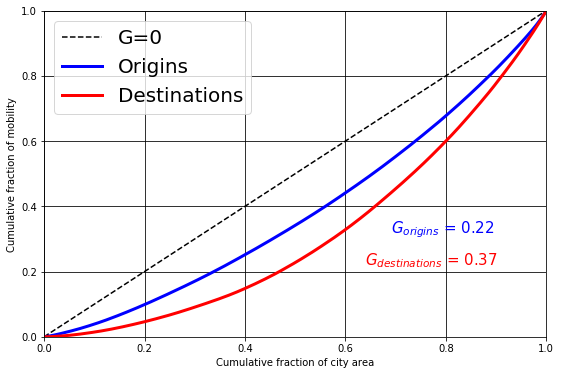

In [75]:
lorenx = (dx*dy*np.arange(0,city['Lres'][0]*city['Lres'][1]) + dx*dy)/(city['Lxy'][1]*city['Lxy'][0])

loreny_org = np.cumsum(np.sort( city['children'] + city['adults'],0)/city['N'])
loreny_dest = np.cumsum(np.sort(visitors,0)/sum(visitors))

G_org = (0.5 - sum(loreny_org)*(lorenx[2]-lorenx[1]))/.5
G_dest = (0.5 - sum(loreny_dest)*(lorenx[2]-lorenx[1]))/0.5

plt.plot([0,1],[0,1],color = 'k',linestyle = '--',label = 'G=0'); plt.grid(color = 'k')
plt.plot(lorenx, loreny_org, color = 'b',linewidth =3, label = 'Origins')
plt.plot(lorenx, loreny_dest,color = 'r',linewidth = 3, label = 'Destinations')

plt.legend(fontsize = 20); plt.xlabel('Cumulative fraction of city area');
plt.ylim((0,1)); plt.xlim((0,1)); plt.ylabel('Cumulative fraction of mobility')

plt.text(0.64, 0.22, '$G_{destinations}$ = ' + str("%.2f" % G_dest), fontsize=15, color = 'r')
plt.text(0.69, 0.32, '$G_{origins}$ = ' + str("%.2f" % G_org), fontsize=15, color = 'b')


Lastly, **calculate $R_0$** for the inhabitants of each neighborhood.

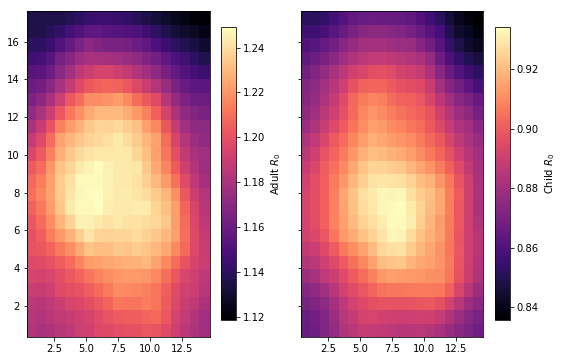

In [76]:
# Calculate number of susceptibles visiting each destination in the city
R0_adult =  np.matmul( np.transpose(mob['adult_OD']), city['adults'],out = None) 
R0_child = np.matmul( np.transpose(mob['child_OD']), city['children'], out = None)

# Now multiply times probability that infective from each origin visits each destination
R0_adult = disease['beta_adults']*np.matmul(mob['alpha']*mob['adult_OD'], R0_adult)/disease['gamma']
R0_child = disease['beta_children']*np.matmul(mob['alpha']*mob['child_OD'], R0_child)/disease['gamma']

# VISUALIZE
img, axs = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, \
                                        squeeze = True)

f1 = axs[0].pcolor(gridx, gridy, np.reshape(R0_adult, (city['Lres'][1],city['Lres'][0])), cmap = 'magma');
f2 = axs[1].pcolor(gridx, gridy, np.reshape(R0_child, (city['Lres'][1], city['Lres'][0])), cmap = 'magma')

cbar = img.colorbar(f1, ax=axs[0], shrink=0.9); cbar.set_label('Adult $R_0$')
cbar = img.colorbar(f2, ax=axs[1], shrink=0.9); cbar.set_label('Child $R_0$')

Now that we've made a rough description of our city's demographics, we can **run a simulation**! Begin by 

In [77]:
# Number of days that you want to run
ndays = 200
# Do you want to try several initial conditions?
in_cond = 10; 
n0 = 5 # number of infectives at t0

# Save number of infectives at each day:
solutions = np.zeros((ndays, in_cond));
cum_cases = np.zeros((ndays, in_cond)); # cumulative number of cases


for jj in np.arange(10):

    # Create arrays for numerical solutions (number of S,I,R people in each location and age group)
    SIR_Adult = np.zeros((len(city['xy']),3))
    SIR_Child = np.zeros((len(city['xy']),3))

    SIR_Adult[:,0] = np.reshape(city['adults'], np.size(SIR_Adult[:,0])); 
    SIR_Child[:,0] = np.reshape(city['children'], np.size(SIR_Child[:,0]));
    
    # Where will this outbreak begin?
    age_group = np.random.randint(2,size = 1)
    location = np.random.randint(len(city['children']), size = 1)
    
    # Introduce n0 infectives at desired origin:
    if age_group == 0 :
        SIR_Adult[location,1] = n0
    elif age_group == 1 :
        SIR_Child[location,1] = n0
        
    for time in np.arange(ndays) :
    
        # Number of infected visitors at each grid element weighed by beta:
        I_map = np.multiply( np.matmul( np.transpose( mob['alpha']*mob['adult_OD'] ), SIR_Adult[:,1] ), \
                            disease['beta_adults']) + np.multiply( np.matmul( np.transpose( \
                            mob['alpha']*mob['child_OD'] ), SIR_Child[:,1] ), disease['beta_children']);
        
        # Now compute expected number of susceptibles visiting each place. Store where they come from, 
        # so we'll know where to allocate new infectives:
        S_trip_adult = np.multiply(mob['adult_OD'], SIR_Adult[:,0])
        S_trip_child = np.multiply(mob['child_OD'], SIR_Child[:,0])
        
        # Now compute interactions and change in number of infectives
        di_Adult = np.matmul(S_trip_adult, I_map)
        di_Child = np.matmul(S_trip_child, I_map)
        
        # Save relevant information
        SIR_Adult[:,0] = SIR_Adult[:,0] - di_Adult; #subtract people falling sick
        SIR_Adult[:,2] = SIR_Adult[:,2] + SIR_Adult[:,1]*disease['gamma'] # add recovery
        SIR_Adult[:,1] = SIR_Adult[:,1]*(1 - disease['gamma'])  + di_Adult; # add falling sick, subtract recovery
        
        SIR_Child[:,0] = SIR_Child[:,0] - di_Child;
        SIR_Child[:,2] = SIR_Child[:,2] + SIR_Child[:,1]*disease['gamma']
        SIR_Child[:,1] = SIR_Child[:,1]*(1 - disease['gamma']) + di_Child
        
        solutions[time, jj] = sum(SIR_Child[:,1] + SIR_Adult[:,1])
        
        if time == 0:
            cum_cases[time,jj] = sum(di_Adult + di_Child)
        else:
            cum_cases[time,jj] = cum_cases[time-1,jj] + sum(di_Adult + di_Child)
    

    

Visualize the results, beginning by the number of infectives at each time

Text(0.5,1,'Model solutions')

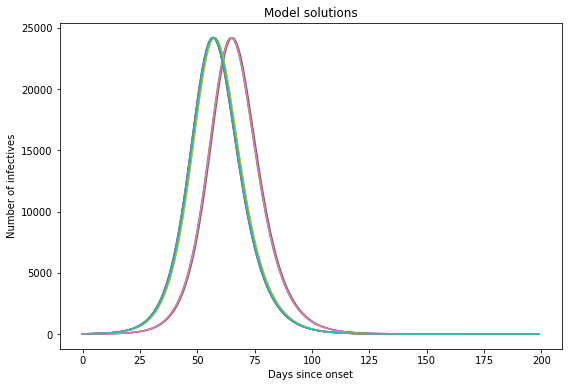

In [78]:
plt.plot(solutions)
plt.ylabel('Number of infectives')
plt.xlabel('Days since onset')
plt.title('Model solutions')

And now the cumulative number of cases, normalized by the size of the population (attack rate)

Text(0.5,0,'Days since onset')

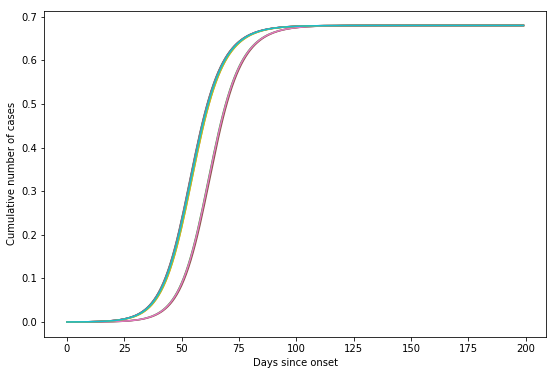

In [79]:
plt.plot(cum_cases/sum(city['adults'] + city['children']))
plt.ylabel('Cumulative number of cases')
plt.xlabel('Days since onset')